# HMM Analysis for Andreev State Spectroscopy

This notebook provides functionality for analyzing Andreev state spectroscopy data
using Hidden Markov Models (HMM).

In [1]:
%load_ext autoreload
%autoreload 2


In [37]:
import quasiparticleFunctions as qp
from hmm_utils import (create_physics_based_transition_matrix,
                          get_means_covars)
from hmm_analysis import HMMAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import seaborn as sns

## Single Power at Fixed Flux Workflow

In [14]:
# Initialize analyzer
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyzer = HMMAnalyzer(data_dir, num_modes=2)

new b


In [15]:
# Load data files
analyzer.load_data_files("phi_0p450")

In [16]:
# Process data for specific attenuation
atten = 26
analyzer.load_and_process_data(atten=atten)

In [7]:
%matplotlib qt


Please click on 2 mode centers

Final mode assignments:


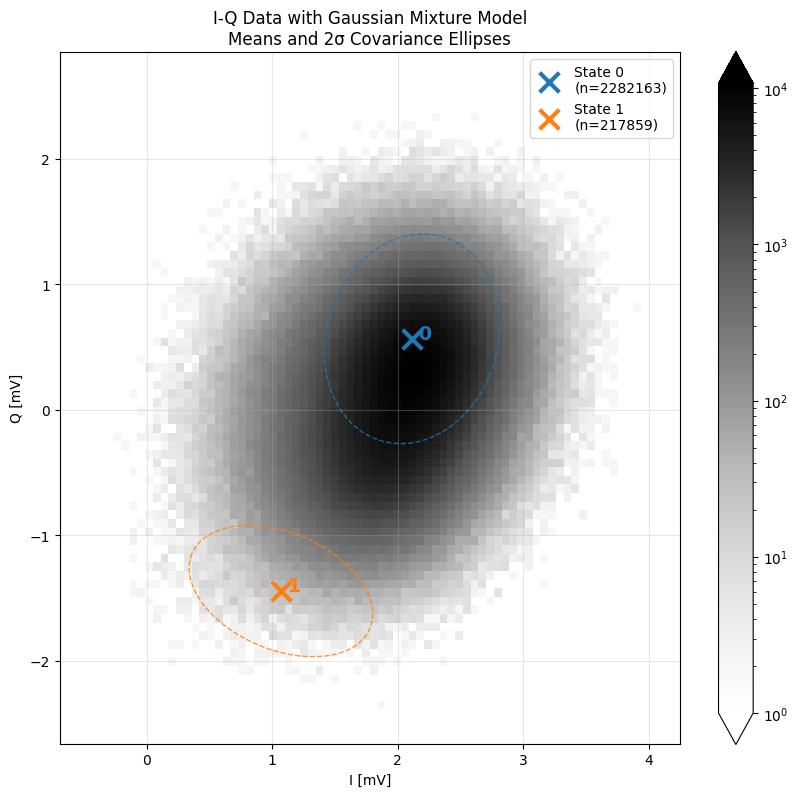

In [8]:
# Get initial parameters
result = get_means_covars(analyzer.data, analyzer.num_modes)
means_guess = result['means']
covars_guess = result['covariances']

In [12]:
means_guess = analyzer.model.means_
covars_guess = analyzer.model.covars_

In [17]:
# Initialize and fit model
analyzer.initialize_model(means_guess, covars_guess)
analyzer.fit_model()

         1    -2626203.8974             +nan
         2    -2237894.8866     +388309.0108
         3    -2213495.8996      +24398.9870
         4    -2207697.3290       +5798.5706
         5    -2206172.1199       +1525.2091
         6    -2205775.0901        +397.0298
         7    -2205671.9778        +103.1123
         8    -2205645.1098         +26.8680
         9    -2205638.0540          +7.0558
        10    -2205636.1789          +1.8751
        11    -2205635.6753          +0.5036
        12    -2205635.5380          +0.1373
        13    -2205635.4999          +0.0380
        14    -2205635.4894          +0.0106
        15    -2205635.4862          +0.0032
        16    -2205635.4853          +0.0008


In [ ]:
# Decode states and calculate probabilities
logprob, states = analyzer.decode_states()
mean_occ, probs = analyzer.calculate_occupation_probabilities(states)
print(f"Mean occupation: {mean_occ}")
print(f"Probabilities: {probs}")

# Save all results and plots
analyzer.save_analysis_results(states, atten, means_guess, covars_guess)

# Calculate SNRs
snrs = analyzer.calculate_snrs()
print("SNRs:", snrs)

Mean occupation: 0.36559198279055144
Probabilities: [0.6344080172094485, 0.36559198279055144]


## Variable Power at Fixed Flux (Bootstrapping) Workflow

In [38]:
def bootstrapping_analysis(analyzer, phi_string, non_linear_atten, snr_threshold):
    analyzer.load_data_files(phi_string)
    attenuations = analyzer.attenuations
    idx = np.where(attenuations == non_linear_atten)[0][0]
    means_guess = None
    covars_guess = None

    results = []  # Collect results for summary plotting

    for i in range(idx, len(attenuations)):
        atten = attenuations[i]
        print(f"\n=== Processing attenuation: {atten} dB ===")
        analyzer.load_and_process_data(atten=atten)
        
        # Get initial parameters for first run, or use previous model's
        if means_guess is None or covars_guess is None:
            result = get_means_covars(analyzer.data, analyzer.num_modes)
            means_guess = result['means']
            covars_guess = result['covariances']
        
        analyzer.initialize_model(means_guess, covars_guess)
        analyzer.fit_model()
        logprob, states = analyzer.decode_states()
        mean_occ, probs = analyzer.calculate_occupation_probabilities(states)
        analyzer.save_analysis_results(states, atten, means_guess, covars_guess)
        snrs = analyzer.calculate_snrs()
        rates = analyzer.calculate_transition_rates()
        
        # Store results
        results.append({
            "atten": atten,
            "mean_occ": mean_occ,
            "probs": probs,
            "snrs": snrs,
            "rates": rates
        })
        
        print(f"Mean occupation: {mean_occ}")
        print(f"Probabilities: {probs}")
        print("SNRs:", snrs)
        
        # Stop if any SNR is below threshold
        if np.any(snrs < snr_threshold):
            print(f"Stopping: SNR below threshold ({snr_threshold})")
            break
        
        # Use current model's means and covariances for next run
        means_guess = analyzer.model.means_
        covars_guess = analyzer.model.covars_

    # Call the summary plotting function
    plot_bootstrap_summary(results, analyzer.num_modes)

def plot_bootstrap_summary(results, num_modes):
    atts = [r["atten"] for r in results]
    mean_occs = [r["mean_occ"] for r in results]
    probs = np.array([r["probs"] for r in results])  # shape: (n, num_modes)
    snrs = np.array([r["snrs"] for r in results])    # shape: (n, num_pairs)
    rates = np.array([r["rates"] for r in results])  # shape: (n, num_modes, num_modes)

    # Plot mean occupation
    plt.figure()
    plt.plot(atts, mean_occs, marker='o')
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Mean Occupation")
    plt.title("Mean Occupation vs Attenuation")
    plt.grid(True)
    plt.show()

    # Plot probabilities
    plt.figure()
    for i in range(num_modes):
        plt.plot(atts, probs[:, i], marker='o', label=f"State {i}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Probability")
    plt.title("State Probabilities vs Attenuation")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot SNRs
    plt.figure()
    for i in range(snrs.shape[1]):
        plt.plot(atts, snrs[:, i], marker='o', label=f"SNR {i}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("SNR")
    plt.title("SNRs vs Attenuation")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot transition rates
    plt.figure()
    for i in range(num_modes):
        for j in range(num_modes):
            if i != j:
                plt.plot(atts, rates[:, i, j], marker='o', label=f"{i}→{j}")
    plt.xlabel("Attenuation (dB)")
    plt.ylabel("Transition Rate (MHz)")
    plt.title("Transition Rates vs Attenuation")
    plt.legend()
    plt.grid(True)
    plt.show()

new b

=== Processing attenuation: 26 dB ===

Please click on 2 mode centers

Final mode assignments:


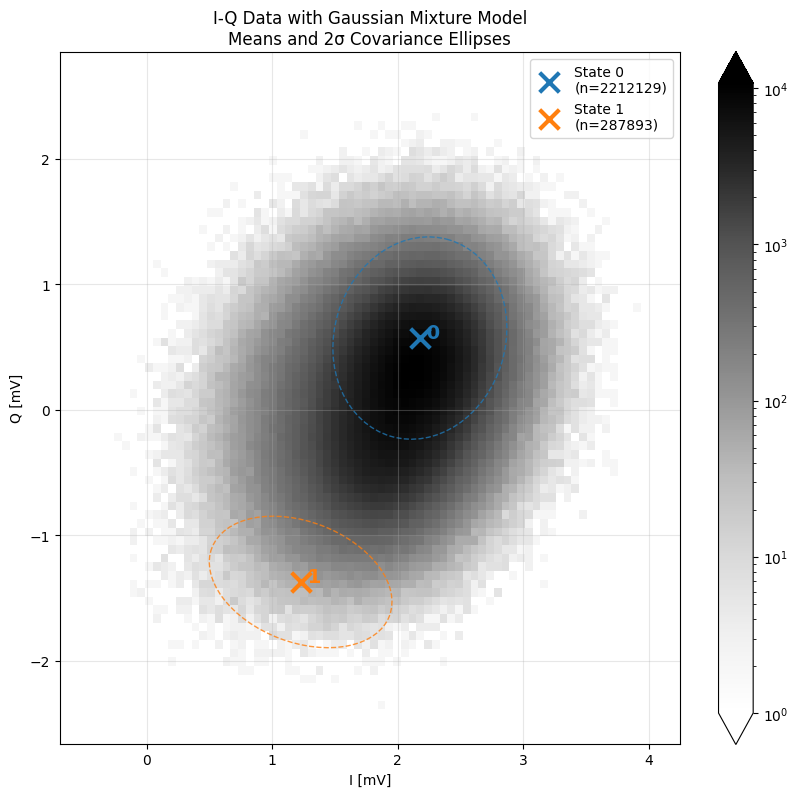

         1    -4326628.4189             +nan
         2    -2723554.4709    +1603073.9480
         3    -2668674.5199      +54879.9510
         4    -2547226.6749     +121447.8450
         5    -2401448.7074     +145777.9675
         6    -2295786.1162     +105662.5913
         7    -2238974.1520      +56811.9641
         8    -2215993.0447      +22981.1073
         9    -2208591.6178       +7401.4270
        10    -2206455.3409       +2136.2769
        11    -2205860.2069        +595.1339
        12    -2205697.0166        +163.1904
        13    -2205652.4177         +44.5989
        14    -2205640.1807         +12.2370
        15    -2205636.8006          +3.3801
        16    -2205635.8577          +0.9429
        17    -2205635.5917          +0.2660
        18    -2205635.5155          +0.0761
        19    -2205635.4939          +0.0217
        20    -2205635.4876          +0.0062
        21    -2205635.4857          +0.0019
        22    -2205635.4852          +0.0006


Mean occupation: 0.36559198279055144
Probabilities: [0.6344080172094485, 0.36559198279055144]
SNRs: [2.45587469]

=== Processing attenuation: 24 dB ===


         1    -4323609.8031             +nan
         2    -2208641.9851    +2114967.8179
         3    -2204810.7159       +3831.2693
         4    -2203552.1514       +1258.5645
         5    -2202493.1058       +1059.0456
         6    -2201539.7661        +953.3396
         7    -2200704.5961        +835.1700
         8    -2200001.7613        +702.8348
         9    -2199437.1437        +564.6176
        10    -2199006.0691        +431.0746
        11    -2198694.0640        +312.0051
        12    -2198479.9801        +214.0840
        13    -2198340.3559        +139.6241
        14    -2198253.3929         +86.9631
        15    -2198201.3387         +52.0542
        16    -2198171.1960         +30.1427
        17    -2198154.1981         +16.9979
        18    -2198144.8088          +9.3892
        19    -2198139.7043          +5.1045
        20    -2198136.9624          +2.7419
        21    -2198135.5015          +1.4609
        22    -2198134.7289          +0.7725
        23

Mean occupation: 0.3428577828515109
Probabilities: [0.6571422171484891, 0.3428577828515109]
SNRs: [0.25215445]
Stopping: SNR below threshold (1.5)


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

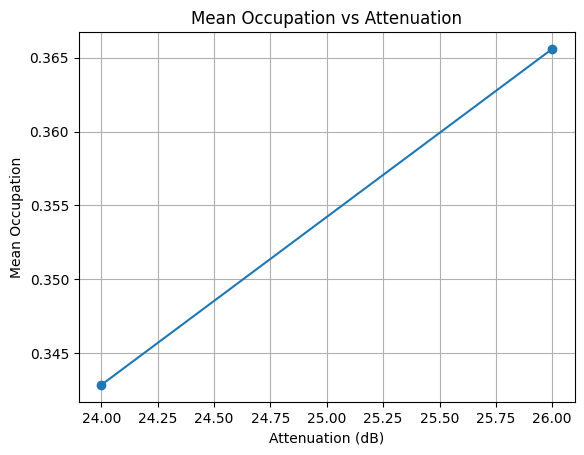

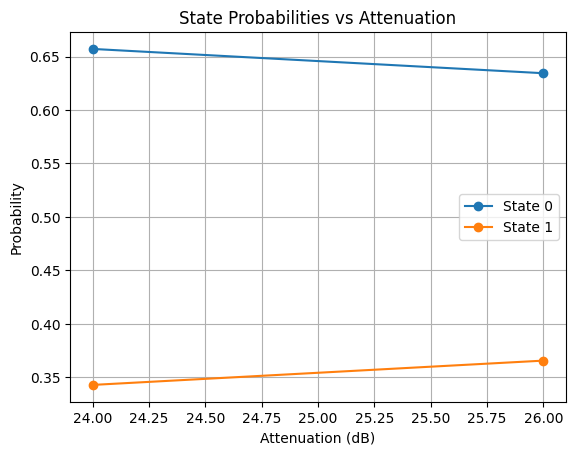

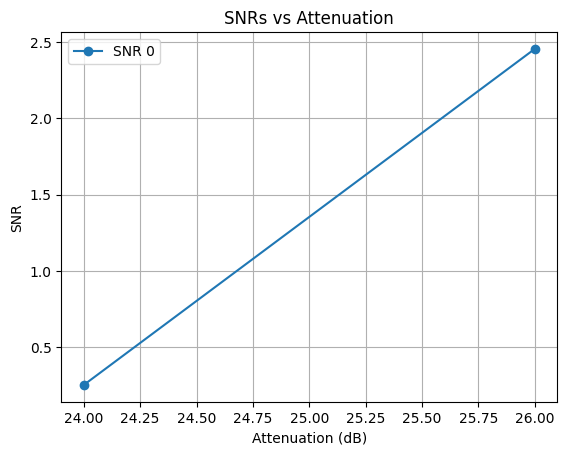

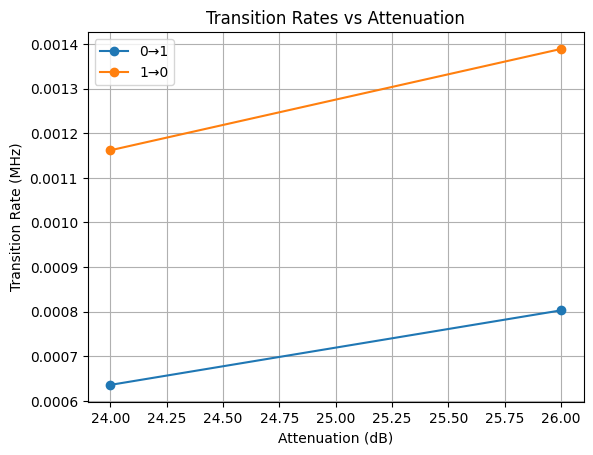

In [41]:
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyzer = HMMAnalyzer(data_dir, num_modes=2)
bootstrapping_analysis(analyzer, "phi_0p450", non_linear_atten=26, snr_threshold=1.5)

## Variable Power and Flux (Bootstrapping) Workflow:

Found phi directories: ['phi_0p450']

=== Running analysis for phi_0p450 ===
new b

=== Processing attenuation: 26 dB ===

Please click on 2 mode centers

Final mode assignments:


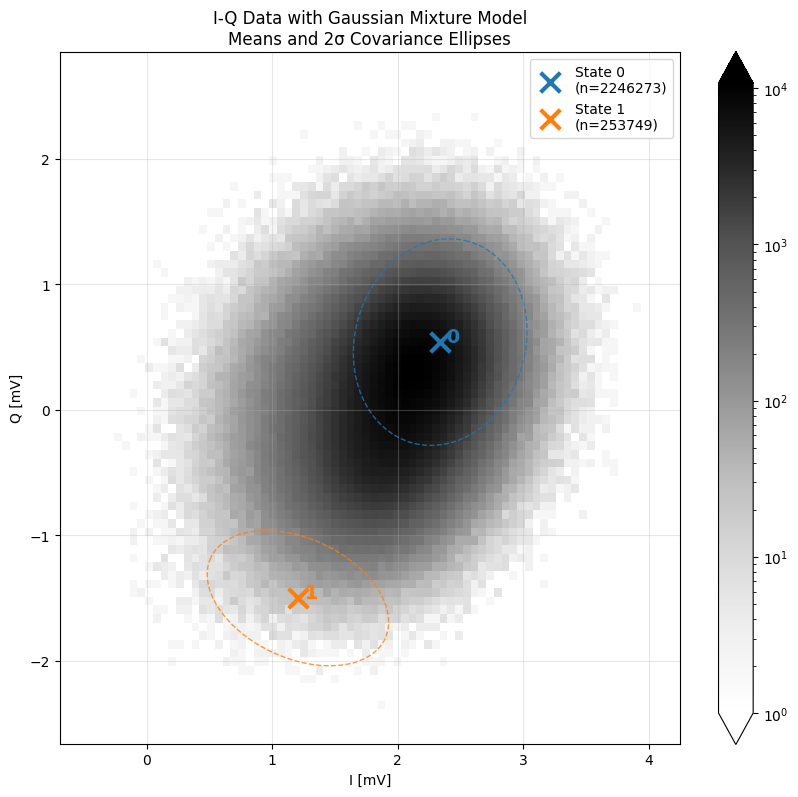

         1    -4729669.2505             +nan
         2    -2738804.9296    +1990864.3209
         3    -2715167.8736      +23637.0560
         4    -2645178.4535      +69989.4201
         5    -2508283.3057     +136895.1478
         6    -2367908.4749     +140374.8308
         7    -2275756.0789      +92152.3960
         8    -2230083.4721      +45672.6068
         9    -2212961.1460      +17122.3261
        10    -2207699.1296       +5262.0164
        11    -2206203.8711       +1495.2585
        12    -2205790.8745        +412.9966
        13    -2205678.0098        +112.8647
        14    -2205647.1937         +30.8161
        15    -2205638.7409          +8.4528
        16    -2205636.3989          +2.3419
        17    -2205635.7448          +0.6541
        18    -2205635.5596          +0.1853
        19    -2205635.5066          +0.0530
        20    -2205635.4912          +0.0153
        21    -2205635.4870          +0.0042
        22    -2205635.4856          +0.0014
        23

Mean occupation: 0.36559198279055144
Probabilities: [0.6344080172094485, 0.36559198279055144]
SNRs: [2.45587229]

=== Processing attenuation: 24 dB ===


         1    -4323609.6411             +nan
         2    -2208641.9749    +2114967.6662
         3    -2204810.7205       +3831.2544
         4    -2203552.1222       +1258.5983
         5    -2202493.0869       +1059.0353
         6    -2201539.7567        +953.3302
         7    -2200704.5815        +835.1752
         8    -2200001.7286        +702.8529
         9    -2199437.1009        +564.6278
        10    -2199006.0578        +431.0431
        11    -2198694.0597        +311.9981
        12    -2198479.9813        +214.0784
        13    -2198340.3561        +139.6252
        14    -2198253.3914         +86.9647
        15    -2198201.3421         +52.0493
        16    -2198171.1963         +30.1458
        17    -2198154.1972         +16.9990
        18    -2198144.8068          +9.3905
        19    -2198139.7038          +5.1029
        20    -2198136.9613          +2.7426
        21    -2198135.5004          +1.4608
        22    -2198134.7285          +0.7719
        23

Mean occupation: 0.3428577828515109
Probabilities: [0.6571422171484891, 0.3428577828515109]
SNRs: [0.25215411]
Stopping: SNR below threshold (1.5)


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

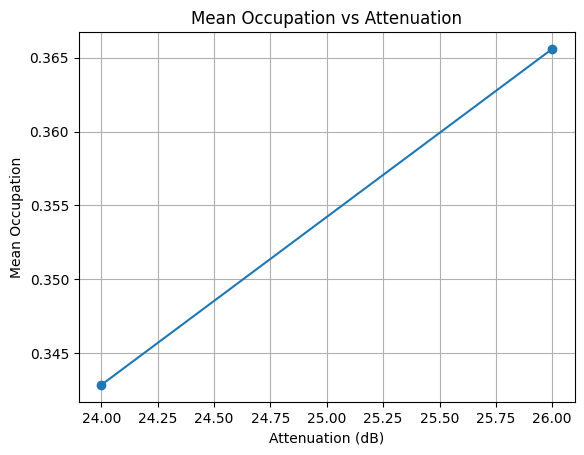

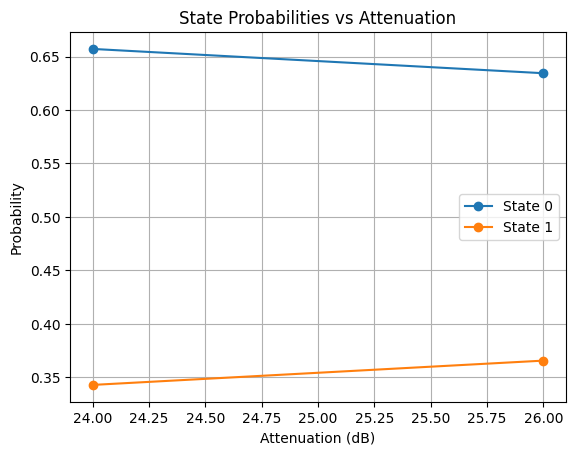

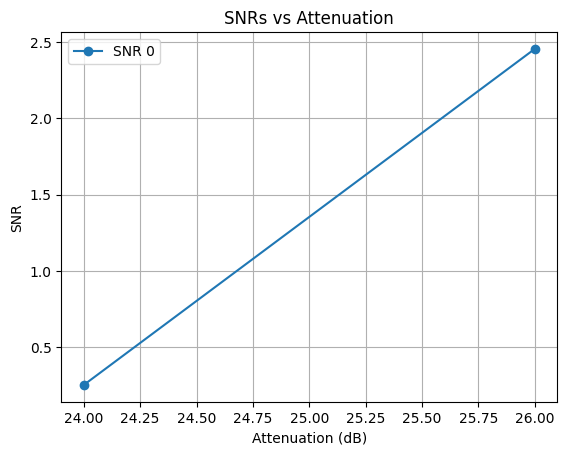

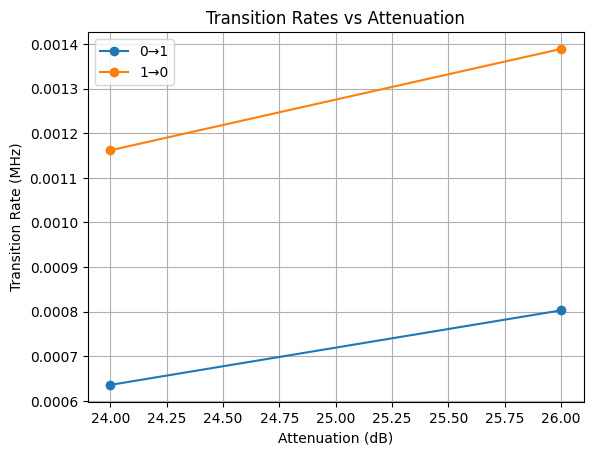

In [42]:
import os
import glob

def analyze_flux_sweep(data_dir, num_modes, non_linear_atten, snr_threshold):
    # Find all phi_* directories
    phi_dirs = sorted(
        [d for d in os.listdir(data_dir) if d.startswith("phi_") and os.path.isdir(os.path.join(data_dir, d))]
    )
    print(f"Found phi directories: {phi_dirs}")

    for phi_string in phi_dirs:
        print(f"\n=== Running analysis for {phi_string} ===")
        analyzer = HMMAnalyzer(data_dir, num_modes=num_modes)
        try:
            bootstrapping_analysis(analyzer, phi_string, non_linear_atten, snr_threshold)
        except Exception as e:
            print(f"Error processing {phi_string}: {e}")

# Usage
data_dir = "/Users/shanto/LFL/HMM_Benchmarking/data/"
analyze_flux_sweep(data_dir, num_modes=2, non_linear_atten=26, snr_threshold=1.5)